In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Read CSV with proper handling
df = pd.read_csv("datasets/marketing_data.csv", sep='\t')

# If tab-separated doesn't work (only 1 column), try comma
if len(df.columns) == 1:
    df = pd.read_csv("datasets/marketing_data.csv", sep=',')

# Strip column names
df.columns = df.columns.str.strip()

print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(df.head(2))

Shape: (2240, 28)
Columns: ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response', 'Complain', 'Country']
     ID  Year_Birth   Education Marital_Status       Income  Kidhome  \
0  1826        1970  Graduation       Divorced  $84,835.00         0   
1     1        1961  Graduation         Single  $57,091.00         0   

   Teenhome Dt_Customer  Recency  MntWines  ...  NumStorePurchases  \
0         0     6/16/14        0       189  ...                  6   
1         0     6/15/14        0       464  ...                  7   

   NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0                  1             0 

In [2]:
# Q1: Examine Dt_Customer and Income to verify accurate importation

# Parse Dt_Customer as datetime
if 'Dt_Customer' in df.columns:
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')
    print('Dt_Customer dtype:', df['Dt_Customer'].dtype)
    # print('Dt_Customer range:', df['Dt_Customer'].min(), '->', df['Dt_Customer'].max())
    # print('Dt_Customer missing:', df['Dt_Customer'].isna().sum())

# Clean and convert Income (remove $ and commas if present)
if 'Income' in df.columns:
    if df['Income'].dtype == 'object':
        df['Income'] = (
            df['Income']
            .astype(str)
            .str.replace(r'[$,]', '', regex=True)
            .str.strip()
        )
        df['Income'] = pd.to_numeric(df['Income'], errors='coerce')
    
    print('\nIncome dtype:', df['Income'].dtype)
    print('Income missing:', df['Income'].isna().sum())
    print('Income summary:')
    print(df['Income'].describe())

Dt_Customer dtype: datetime64[ns]

Income dtype: float64
Income missing: 24
Income summary:
count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64


/var/folders/ry/hmwdqb7950b9qsykrtzp91zm0000gr/T/ipykernel_60152/744174291.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')


In [3]:
# Q2: Clean Education/Marital_Status and impute missing Income

# Clean categorical columns
for col in ['Education', 'Marital_Status']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Standardize Education categories
df['Education'] = df['Education'].replace({'2n Cycle': '2nd Cycle'})

# Standardize Marital_Status categories  
df['Marital_Status'] = df['Marital_Status'].replace({
    'Alone': 'Single',
    'Absurd': 'Other',
    'YOLO': 'Other'
})

print('Education value counts:')
print(df['Education'].value_counts())
print('\nMarital_Status value counts:')
print(df['Marital_Status'].value_counts())

# Impute missing Income using group means (Education + Marital_Status)
missing_before = df['Income'].isna().sum()

# Calculate group means
group_means = df.groupby(['Education', 'Marital_Status'])['Income'].transform('mean')
edu_means = df.groupby('Education')['Income'].transform('mean')
overall_median = df['Income'].median()

# Fill missing values with cascading fallbacks
df['Income'] = df['Income'].fillna(group_means)
df['Income'] = df['Income'].fillna(edu_means)
df['Income'] = df['Income'].fillna(overall_median)

missing_after = df['Income'].isna().sum()
print(f'\nIncome missing before imputation: {missing_before}')
print(f'Income missing after imputation: {missing_after}')

Education value counts:
Education
Graduation    1127
PhD            486
Master         370
2nd Cycle      203
Basic           54
Name: count, dtype: int64

Marital_Status value counts:
Marital_Status
Married     864
Together    580
Single      483
Divorced    232
Widow        77
Other         4
Name: count, dtype: int64

Income missing before imputation: 24
Income missing after imputation: 0


In [4]:
# Q3: Create Total_Children, Age, Total_Spending, Total_Purchases

# Total number of children
df['Total_Children'] = df['Kidhome'] + df['Teenhome']

# Age (current year - birth year)
current_year = 2025
df['Age'] = current_year - df['Year_Birth']

# Total spending across all product categories
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spending'] = df[spending_cols].sum(axis=1)

# Q3a: Total purchases from the three channels (Web, Catalog, Store)
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)

print('New variables created:')
print(df[['Total_Children', 'Age', 'Total_Spending', 'Total_Purchases']].describe())

New variables created:
       Total_Children          Age  Total_Spending  Total_Purchases
count     2240.000000  2240.000000     2240.000000      2240.000000
mean         0.950446    56.194196      605.798214        12.537054
std          0.751803    11.984069      602.249288         7.205741
min          0.000000    29.000000        5.000000         0.000000
25%          0.000000    48.000000       68.750000         6.000000
50%          1.000000    55.000000      396.000000        12.000000
75%          1.000000    66.000000     1045.500000        18.000000
max          3.000000   132.000000     2525.000000        32.000000


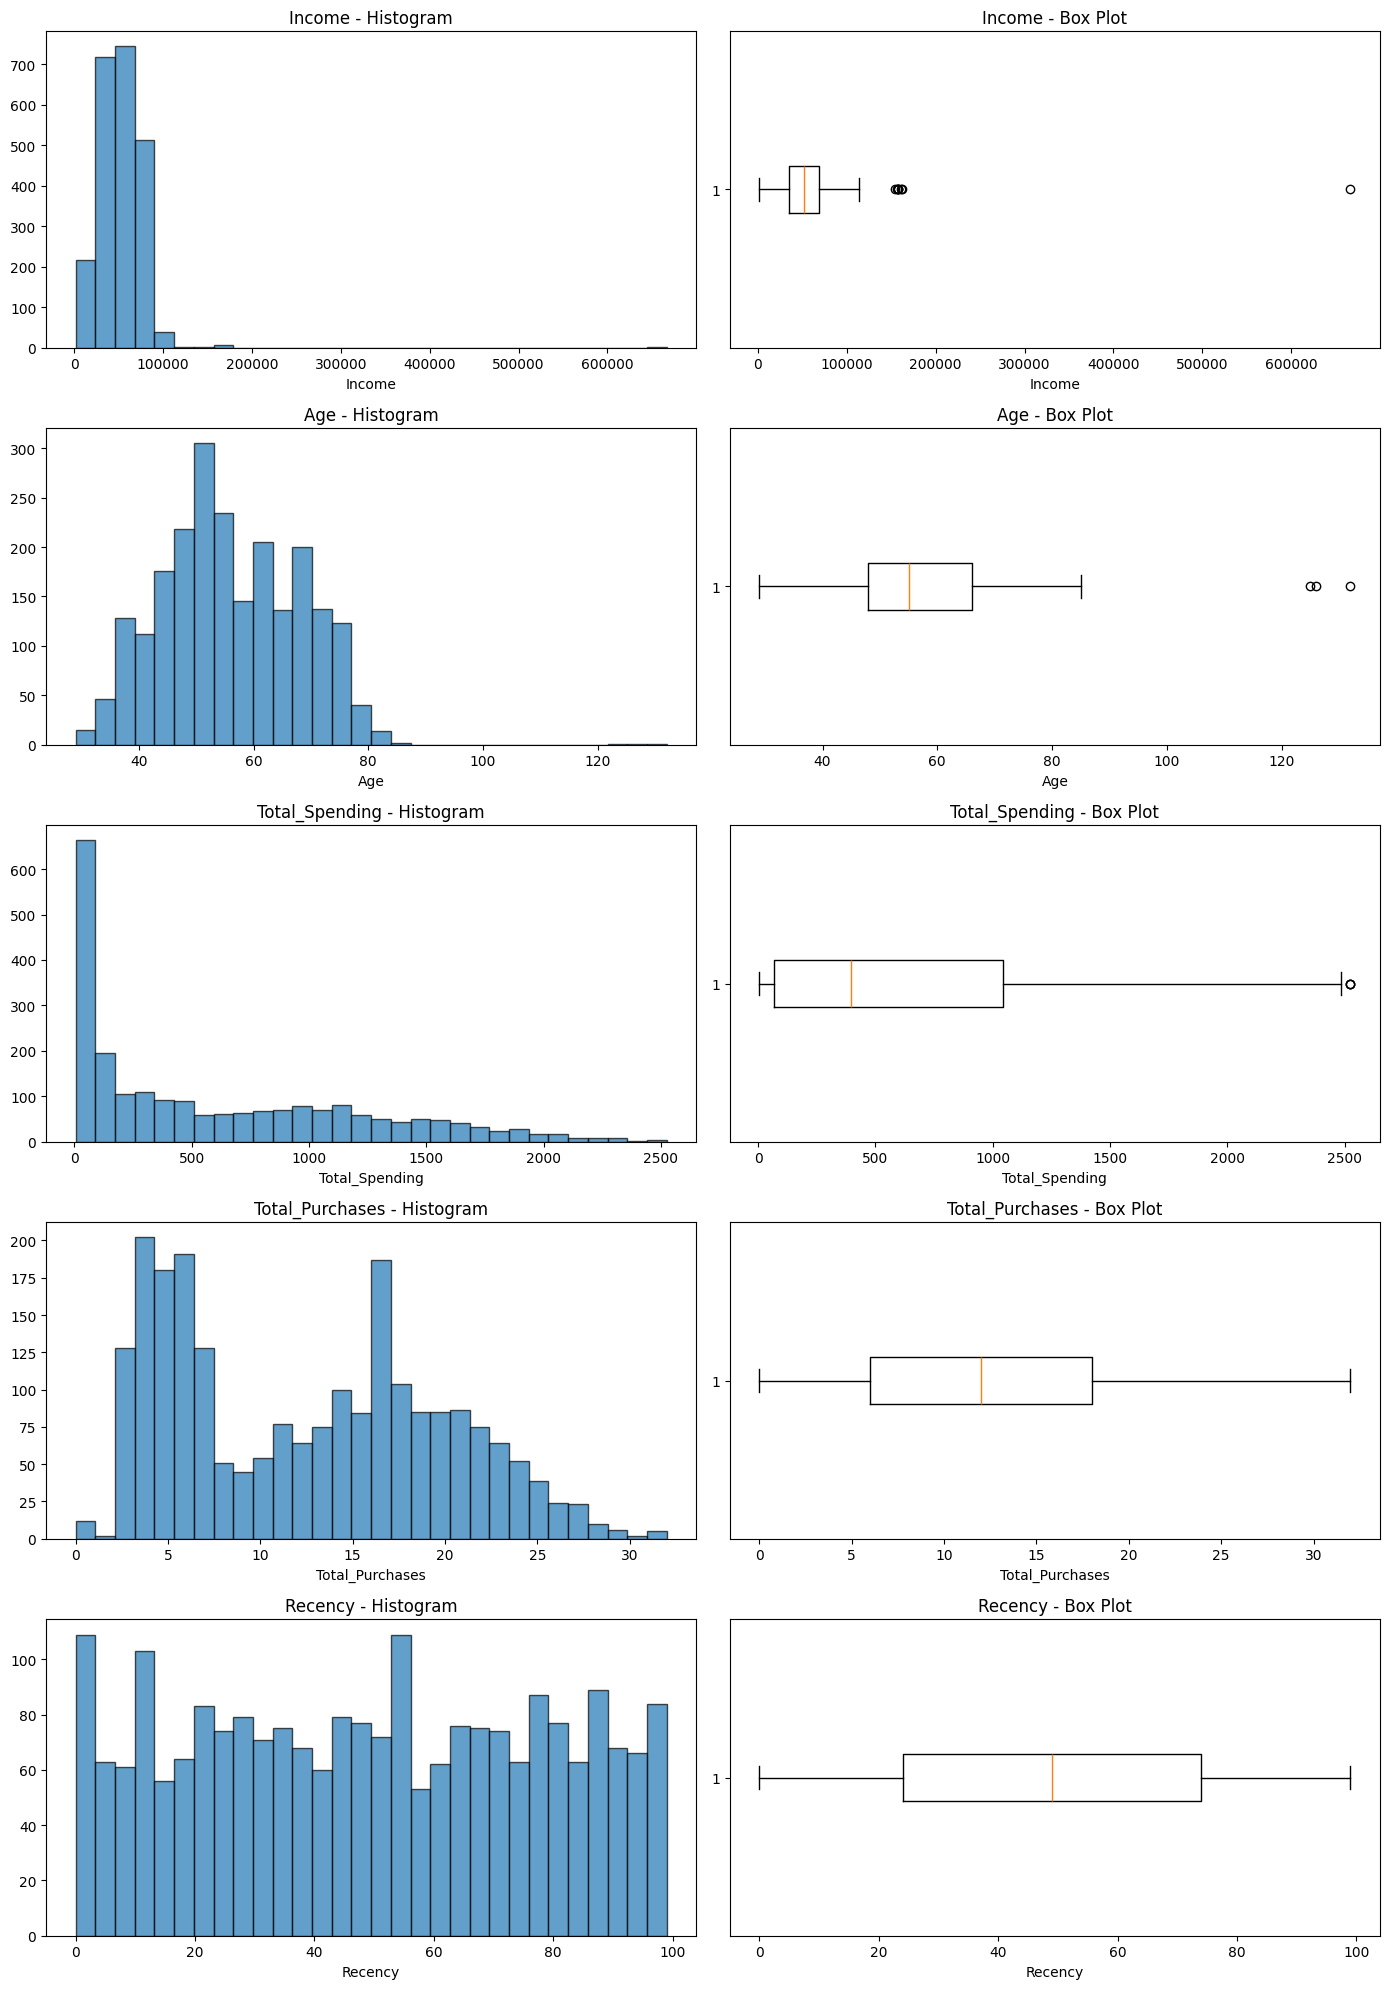


--- Outlier Detection (IQR method) ---
Income:
  - Outliers found: 8
  - Valid range: -13587.75 to 117416.25
Age:
  - Outliers found: 3
  - Valid range: 21.00 to 93.00
Total_Spending:
  - Outliers found: 3
  - Valid range: -1396.38 to 2510.62
Total_Purchases:
  - Outliers found: 0
  - Valid range: -12.00 to 36.00
Recency:
  - Outliers found: 0
  - Valid range: -51.00 to 149.00


In [5]:
# Q4: Box plots and histograms for distributions + outlier treatment

# Step 1: Select the columns we want to analyze
numeric_cols = ['Income', 'Age', 'Total_Spending', 'Total_Purchases', 'Recency']

# Step 2: Create visualizations (Histogram + Box Plot for each column)
# We'll create 2 plots per column: one histogram, one box plot
num_columns = len(numeric_cols)
fig, axes = plt.subplots(num_columns, 2, figsize=(14, 4*num_columns))

# Step 3: Loop through each column and create plots
for i, col in enumerate(numeric_cols):
    # LEFT PLOT: Histogram (shows the distribution of data)
    # A histogram shows how many values fall into different ranges
    axes[i, 0].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[i, 0].set_title(f'{col} - Histogram')
    axes[i, 0].set_xlabel(col)
    
    # RIGHT PLOT: Box Plot (shows outliers and quartiles)
    # The box shows the middle 50% of data, and dots outside are outliers
    axes[i, 1].boxplot(df[col].dropna(), vert=False)
    axes[i, 1].set_title(f'{col} - Box Plot')
    axes[i, 1].set_xlabel(col)

plt.tight_layout()
plt.show()

# Step 4: Detect outliers using IQR (Interquartile Range) method
print('\n--- Outlier Detection (IQR method) ---')

for col in numeric_cols:
    # Calculate quartiles
    Q1 = df[col].quantile(0.25)  # 25th percentile (first quartile)
    Q3 = df[col].quantile(0.75)  # 75th percentile (third quartile)
    IQR = Q3 - Q1                # Interquartile range
    
    # Calculate outlier boundaries
    lower_bound = Q1 - 1.5 * IQR  # Values below this are outliers
    upper_bound = Q3 + 1.5 * IQR  # Values above this are outliers
    
    # Find outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    # Display results
    print(f'{col}:')
    print(f'  - Outliers found: {len(outliers)}')
    print(f'  - Valid range: {lower_bound:.2f} to {upper_bound:.2f}')

In [6]:
# Q4: Outlier Treatment - Cap outliers using IQR

def cap_outliers(df, col):
    """Cap outliers at IQR bounds"""
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply outlier treatment to key numeric columns
outlier_cols = ['Income', 'Age', 'Total_Spending']
for col in outlier_cols:
    df = cap_outliers(df, col)

print('Outliers capped. Summary after treatment:')
print(df[outlier_cols].describe())

Outliers capped. Summary after treatment:
              Income          Age  Total_Spending
count    2240.000000  2240.000000     2240.000000
mean    51876.301327    56.147768      605.779408
std     20938.713138    11.771725      602.189559
min      1730.000000    29.000000        5.000000
25%     35538.750000    48.000000       68.750000
50%     51381.500000    55.000000      396.000000
75%     68289.750000    66.000000     1045.500000
max    117416.250000    93.000000     2510.625000


In [7]:
# 5.	Apply ordinal and one-hot encoding based on the various types of categorical variables.

education_order = {'Basic': 1, '2nd Cycle': 2, 'Graduation': 3, 'Master': 4, 'PhD': 5}
df['Education_Ordinal'] = df['Education'].map(education_order)

print('Education Ordinal Encoding:')
print(df[['Education', 'Education_Ordinal']].drop_duplicates().sort_values('Education_Ordinal'))

# One-Hot Encoding for Marital_Status (no natural order)
marital_dummies = pd.get_dummies(df['Marital_Status'], prefix='Marital', drop_first=True)
df = pd.concat([df, marital_dummies], axis=1)

print('\nOne-Hot Encoded Marital_Status columns:')
print(marital_dummies.columns.tolist())

# One-Hot Encoding for Country
country_dummies = pd.get_dummies(df['Country'], prefix='Country', drop_first=True)
df = pd.concat([df, country_dummies], axis=1)


Education Ordinal Encoding:
     Education  Education_Ordinal
54       Basic                  1
6    2nd Cycle                  2
0   Graduation                  3
11      Master                  4
5          PhD                  5

One-Hot Encoded Marital_Status columns:
['Marital_Married', 'Marital_Other', 'Marital_Single', 'Marital_Together', 'Marital_Widow']


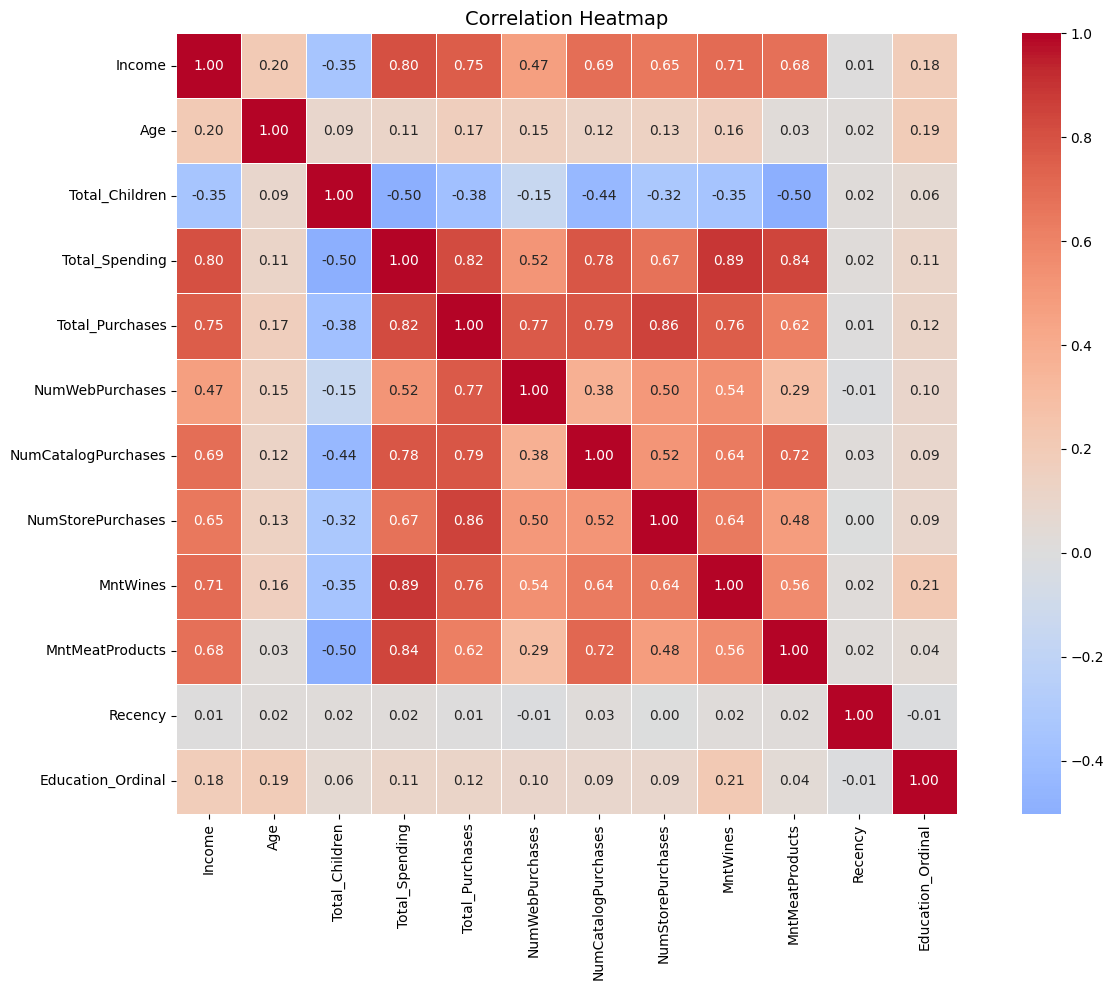


Key Correlations with Total_Spending:
Total_Spending         1.000000
MntWines               0.891845
MntMeatProducts        0.842949
Total_Purchases        0.820734
Income                 0.803746
NumCatalogPurchases    0.778616
NumStorePurchases      0.674695
NumWebPurchases        0.519886
Age                    0.113313
Education_Ordinal      0.107613
Recency                0.020445
Total_Children        -0.498898
Name: Total_Spending, dtype: float64


In [8]:
# Q6: Generate a heatmap to illustrate the correlation between different pairs of variables.

# Select numeric columns for correlation
corr_cols = ['Income', 'Age', 'Total_Children', 'Total_Spending', 'Total_Purchases',
             'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
             'MntWines', 'MntMeatProducts', 'Recency', 'Education_Ordinal']

corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            linewidths=0.5, square=True)
plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

# Key correlations
print('\nKey Correlations with Total_Spending:')
print(corr_matrix['Total_Spending'].sort_values(ascending=False))

In [9]:
# Q7: Hypothesis Testing

# Q7a: Older individuals prefer in-store shopping
# H0: No correlation between Age and NumStorePurchases
# H1: Positive correlation (older people prefer store shopping)

corr_age_store, p_val_age_store = stats.pearsonr(df['Age'], df['NumStorePurchases'])
print('Q7a: Age vs In-Store Shopping Preference')
print(f'Correlation: {corr_age_store:.4f}, p-value: {p_val_age_store:.4f}')
if p_val_age_store < 0.05 and corr_age_store > 0:
    print('Result: SUPPORTED - Older individuals show preference for in-store shopping')
else:
    print('Result: NOT SUPPORTED - No significant evidence for this hypothesis')

# Q7b: Customers with children prefer online shopping
# Compare NumWebPurchases between customers with and without children
with_children = df[df['Total_Children'] > 0]['NumWebPurchases']
without_children = df[df['Total_Children'] == 0]['NumWebPurchases']

t_stat_children, p_val_children = stats.ttest_ind(with_children, without_children)
print(f'\nQ7b: Children vs Online Shopping')
print(f'Mean web purchases (with children): {with_children.mean():.2f}')
print(f'Mean web purchases (without children): {without_children.mean():.2f}')
print(f't-statistic: {t_stat_children:.4f}, p-value: {p_val_children:.4f}')
if p_val_children < 0.05 and with_children.mean() > without_children.mean():
    print('Result: SUPPORTED - Customers with children prefer online shopping')
else:
    print('Result: NOT SUPPORTED - No significant evidence for this hypothesis')

Q7a: Age vs In-Store Shopping Preference
Correlation: 0.1344, p-value: 0.0000
Result: SUPPORTED - Older individuals show preference for in-store shopping

Q7b: Children vs Online Shopping
Mean web purchases (with children): 3.96
Mean web purchases (without children): 4.39
t-statistic: -3.3245, p-value: 0.0009
Result: NOT SUPPORTED - No significant evidence for this hypothesis


In [10]:
# Q7c: Store sales cannibalization by other channels
# Test correlation between store purchases and web/catalog purchases

corr_store_web, p_store_web = stats.pearsonr(df['NumStorePurchases'], df['NumWebPurchases'])
corr_store_cat, p_store_cat = stats.pearsonr(df['NumStorePurchases'], df['NumCatalogPurchases'])

print('Q7c: Store Sales Cannibalization')
print(f'Store vs Web correlation: {corr_store_web:.4f}, p-value: {p_store_web:.4f}')
print(f'Store vs Catalog correlation: {corr_store_cat:.4f}, p-value: {p_store_cat:.4f}')

if corr_store_web < 0 and p_store_web < 0.05:
    print('Result: Evidence of cannibalization by Web channel')
elif corr_store_web > 0:
    print('Result: NO CANNIBALIZATION - Channels are complementary (positive correlation)')
else:
    print('Result: No significant evidence of cannibalization')

# Q7d: US vs Rest of World - Total Purchase Volumes
# H0: No difference in purchase volumes between US and other countries
print('\nQ7d: US vs Rest of World - Total Purchase Volumes')

if 'Country' in df.columns:
    us_purchases = df[df['Country'] == 'US']['Total_Purchases']
    other_purchases = df[df['Country'] != 'US']['Total_Purchases']
    
    if len(us_purchases) > 0:
        t_stat_us, p_val_us = stats.ttest_ind(us_purchases, other_purchases)
        print(f'US mean purchases: {us_purchases.mean():.2f} (n={len(us_purchases)})')
        print(f'Other countries mean purchases: {other_purchases.mean():.2f} (n={len(other_purchases)})')
        print(f't-statistic: {t_stat_us:.4f}, p-value: {p_val_us:.4f}')
        
        if p_val_us < 0.05 and us_purchases.mean() > other_purchases.mean():
            print('Result: SUPPORTED - US significantly outperforms rest of world')
        else:
            print('Result: NOT SUPPORTED - No significant difference or US does not outperform')
    else:
        print('No US customers found in dataset')
        print('Countries in dataset:', df['Country'].unique())

Q7c: Store Sales Cannibalization
Store vs Web correlation: 0.5027, p-value: 0.0000
Store vs Catalog correlation: 0.5187, p-value: 0.0000
Result: NO CANNIBALIZATION - Channels are complementary (positive correlation)

Q7d: US vs Rest of World - Total Purchase Volumes
US mean purchases: 13.51 (n=109)
Other countries mean purchases: 12.49 (n=2131)
t-statistic: 1.4512, p-value: 0.1469
Result: NOT SUPPORTED - No significant difference or US does not outperform


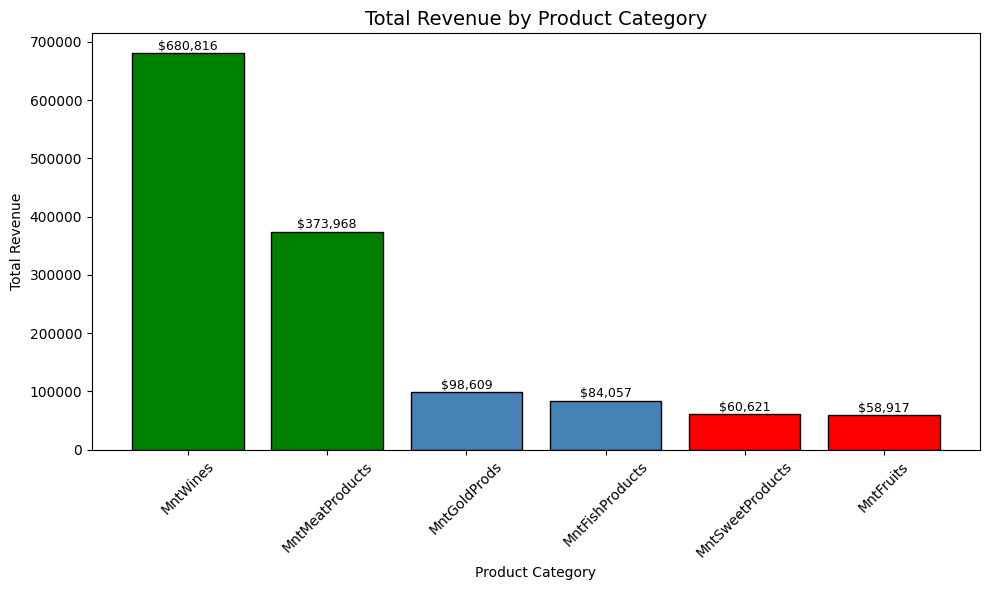

Top Performers (Green): ['MntWines', 'MntMeatProducts']
Lowest Performers (Red): ['MntSweetProducts', 'MntFruits']


In [11]:
# Q8a: Top-performing products and lowest revenue products

product_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
product_revenue = df[product_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors = ['green' if i < 2 else 'red' if i >= len(product_revenue)-2 else 'steelblue' 
          for i in range(len(product_revenue))]
bars = plt.bar(product_revenue.index, product_revenue.values, color=colors, edgecolor='black')
plt.title('Total Revenue by Product Category', fontsize=14)
plt.xlabel('Product Category')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)

for bar, val in zip(bars, product_revenue.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
             f'${val:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print('Top Performers (Green):', product_revenue.head(2).index.tolist())
print('Lowest Performers (Red):', product_revenue.tail(2).index.tolist())

/var/folders/ry/hmwdqb7950b9qsykrtzp91zm0000gr/T/ipykernel_60152/1654041913.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acceptance_by_age = df.groupby('Age_Group')['Response'].mean() * 100


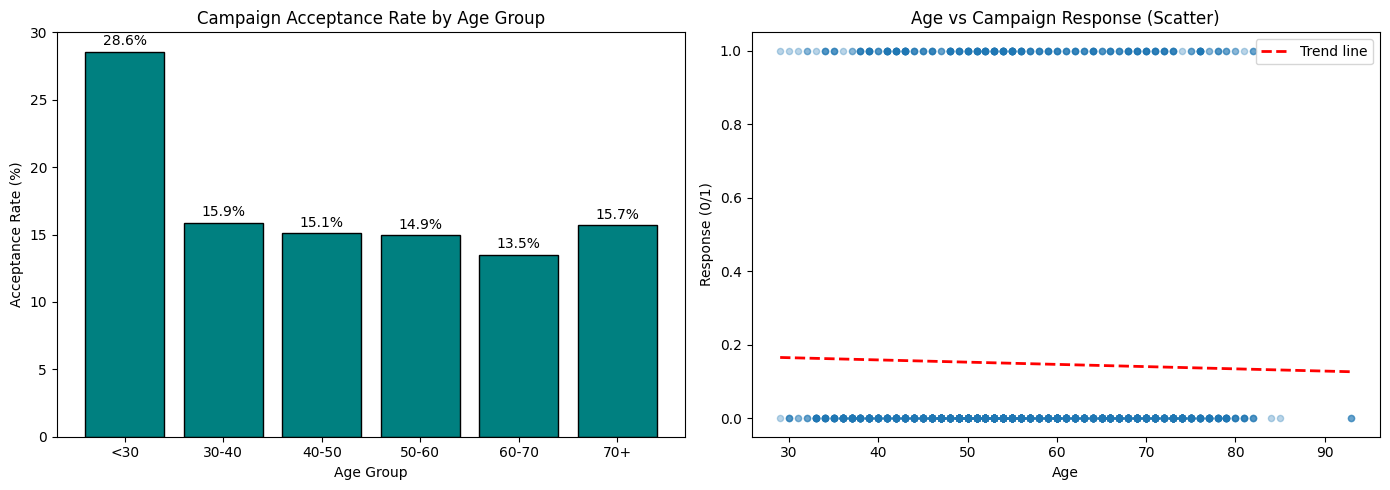

Correlation (Age vs Response): -0.0201, p-value: 0.3427


In [12]:
# Q8b: Age vs Acceptance Rate of Last Campaign (Response column)

# Create age groups for better visualization
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, 70, 100], 
                         labels=['<30', '30-40', '40-50', '50-60', '60-70', '70+'])

acceptance_by_age = df.groupby('Age_Group')['Response'].mean() * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
axes[0].bar(acceptance_by_age.index.astype(str), acceptance_by_age.values, 
            color='teal', edgecolor='black')
axes[0].set_title('Campaign Acceptance Rate by Age Group', fontsize=12)
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Acceptance Rate (%)')
for i, v in enumerate(acceptance_by_age.values):
    axes[0].text(i, v + 0.5, f'{v:.1f}%', ha='center')

# Scatter plot with trend line
axes[1].scatter(df['Age'], df['Response'], alpha=0.3, s=20)
z = np.polyfit(df['Age'], df['Response'], 1)
p = np.poly1d(z)
axes[1].plot(df['Age'].sort_values(), p(df['Age'].sort_values()), 
             'r--', linewidth=2, label='Trend line')
axes[1].set_title('Age vs Campaign Response (Scatter)', fontsize=12)
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Response (0/1)')
axes[1].legend()

plt.tight_layout()
plt.show()

corr_age_response, p_val = stats.pearsonr(df['Age'], df['Response'])
print(f'Correlation (Age vs Response): {corr_age_response:.4f}, p-value: {p_val:.4f}')

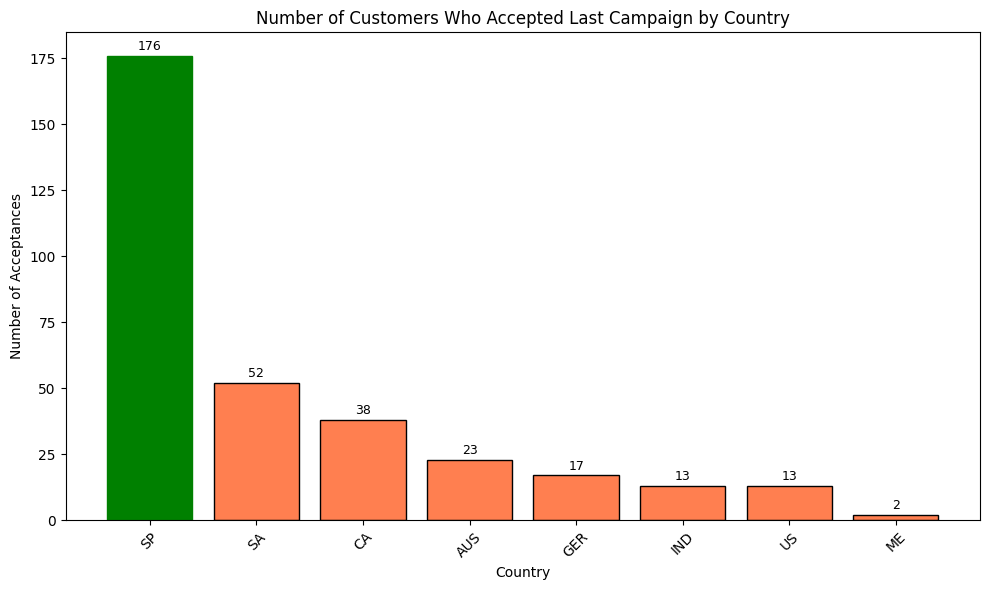

Country with highest campaign acceptance: SP (176 customers)


In [13]:
# Q8c: Country with highest number of customers who accepted last campaign

acceptance_by_country = df[df['Response'] == 1].groupby('Country').size().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(acceptance_by_country.index, acceptance_by_country.values, 
               color='coral', edgecolor='black')
plt.title('Number of Customers Who Accepted Last Campaign by Country', fontsize=12)
plt.xlabel('Country')
plt.ylabel('Number of Acceptances')
plt.xticks(rotation=45)

# Highlight top country
bars[0].set_color('green')

for bar, val in zip(bars, acceptance_by_country.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             str(val), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f'Country with highest campaign acceptance: {acceptance_by_country.index[0]} ({acceptance_by_country.values[0]} customers)')

/var/folders/ry/hmwdqb7950b9qsykrtzp91zm0000gr/T/ipykernel_60152/3976687271.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(children_groups, labels=sorted(df['Total_Children'].unique()))


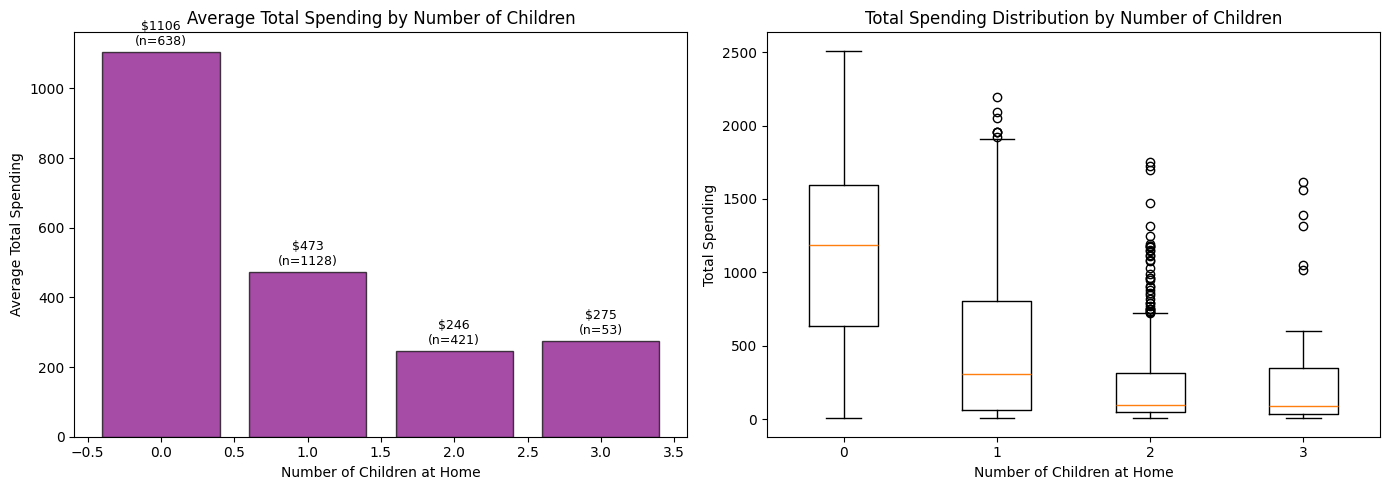

Correlation (Children vs Spending): -0.4989, p-value: 0.0000
Pattern: Negative relationship - More children = Less spending


In [14]:
# Q8d: Pattern between number of children at home and total expenditure

spending_by_children = df.groupby('Total_Children')['Total_Spending'].agg(['mean', 'median', 'count'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart - Mean spending by number of children
axes[0].bar(spending_by_children.index, spending_by_children['mean'], 
            color='purple', edgecolor='black', alpha=0.7)
axes[0].set_title('Average Total Spending by Number of Children', fontsize=12)
axes[0].set_xlabel('Number of Children at Home')
axes[0].set_ylabel('Average Total Spending')
for i, (idx, row) in enumerate(spending_by_children.iterrows()):
    axes[0].text(idx, row['mean'] + 20, f'${row["mean"]:.0f}\n(n={int(row["count"])})', 
                 ha='center', fontsize=9)

# Box plot
children_groups = [df[df['Total_Children'] == i]['Total_Spending'].values 
                   for i in sorted(df['Total_Children'].unique())]
axes[1].boxplot(children_groups, labels=sorted(df['Total_Children'].unique()))
axes[1].set_title('Total Spending Distribution by Number of Children', fontsize=12)
axes[1].set_xlabel('Number of Children at Home')
axes[1].set_ylabel('Total Spending')

plt.tight_layout()
plt.show()

# Statistical test
corr_children_spending, p_val = stats.pearsonr(df['Total_Children'], df['Total_Spending'])
print(f'Correlation (Children vs Spending): {corr_children_spending:.4f}, p-value: {p_val:.4f}')
print(f'Pattern: {"Negative" if corr_children_spending < 0 else "Positive"} relationship - '
      f'{"More children = Less spending" if corr_children_spending < 0 else "More children = More spending"}')

posx and posy should be finite values
posx and posy should be finite values


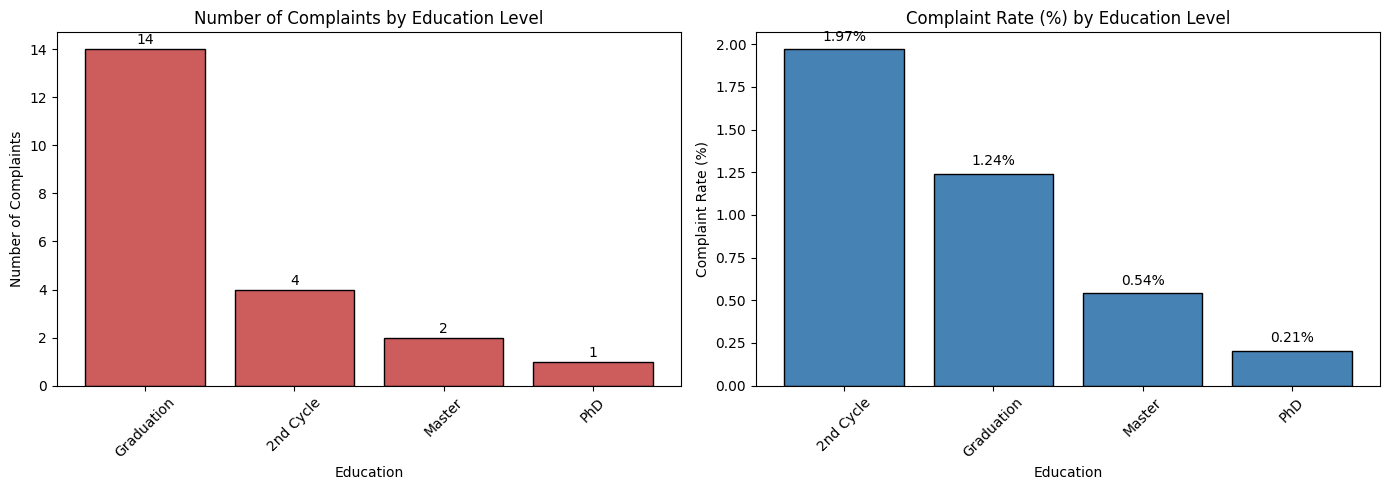

Total complaints: 21

Complaints by Education:
Education
Graduation    14
2nd Cycle      4
Master         2
PhD            1
Name: count, dtype: int64

Complaint Rate by Education:
Education
2nd Cycle     1.97
Graduation    1.24
Master        0.54
PhD           0.21
Basic          NaN
Name: count, dtype: float64


In [15]:
# Q8e: Educational background of customers who lodged complaints in last two years

complaints_df = df[df['Complain'] == 1]

complaints_by_education = complaints_df['Education'].value_counts()
total_by_education = df['Education'].value_counts()
complaint_rate = (complaints_by_education / total_by_education * 100).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count of complaints by education
axes[0].bar(complaints_by_education.index, complaints_by_education.values, 
            color='indianred', edgecolor='black')
axes[0].set_title('Number of Complaints by Education Level', fontsize=12)
axes[0].set_xlabel('Education')
axes[0].set_ylabel('Number of Complaints')
axes[0].tick_params(axis='x', rotation=45)
for i, (idx, val) in enumerate(complaints_by_education.items()):
    axes[0].text(i, val + 0.2, str(val), ha='center')

# Complaint rate by education
axes[1].bar(complaint_rate.index, complaint_rate.values, 
            color='steelblue', edgecolor='black')
axes[1].set_title('Complaint Rate (%) by Education Level', fontsize=12)
axes[1].set_xlabel('Education')
axes[1].set_ylabel('Complaint Rate (%)')
axes[1].tick_params(axis='x', rotation=45)
for i, (idx, val) in enumerate(complaint_rate.items()):
    axes[1].text(i, val + 0.05, f'{val:.2f}%', ha='center')

plt.tight_layout()
plt.show()

print(f'Total complaints: {len(complaints_df)}')
print('\nComplaints by Education:')
print(complaints_by_education)
print('\nComplaint Rate by Education:')
print(complaint_rate.round(2))